## Wesley Mitchell
### ViT Model Implementation

In [107]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

#### Load the Pretraining MNIST Dataset

In [108]:
#function to load images
def load_images(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)
    img = float(img) / 255.0
    return img

#function to convert string to numbers
def string_to_numbers(label_str):
    return tf.strings.to_number(tf.strings.split(label_str, ', '), out_type=tf.int32)
    
        
#function to load the dataset with examples and labels
def load_dataset(images_dir, labels_path):
    img_file_paths = tf.data.Dataset.list_files(images_dir + '/*.png', shuffle=False)
    images_dataset = img_file_paths.map(load_images)
    
    labels_dataset = tf.data.TextLineDataset(labels_path)
    labels_dataset = labels_dataset.map(string_to_numbers)
    
    dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))
    
    return dataset

#load training set
train_images_dir = "../dataset/Pretraining/train/examples"
train_labels_path = "../dataset/Pretraining/train/labels.txt"
train = load_dataset(train_images_dir, train_labels_path)


#load validation set
valid_images_dir = "../dataset/Pretraining/validation/examples"
valid_labels_path = "../dataset/Pretraining/validation/labels.txt"
validation = load_dataset(valid_images_dir, valid_labels_path)
    
    

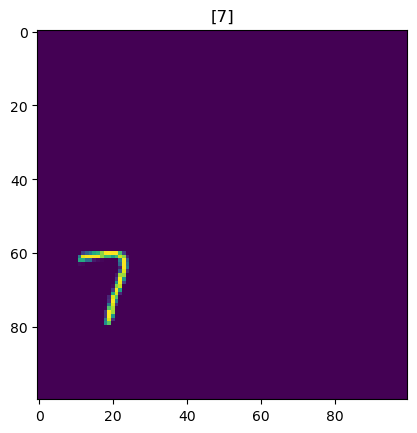

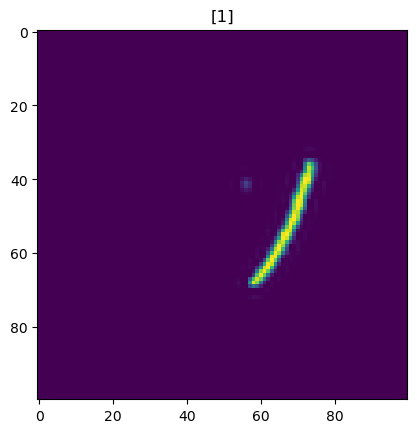

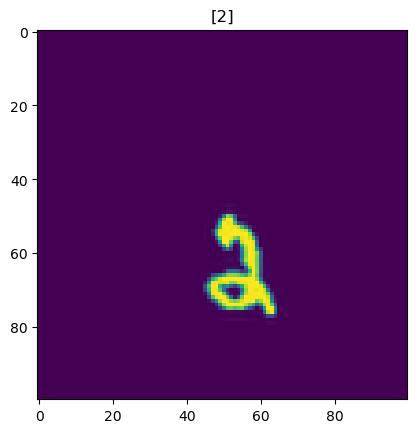

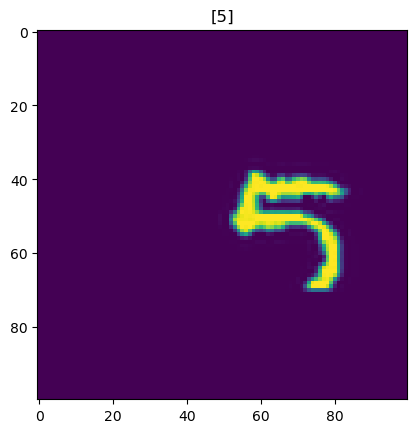

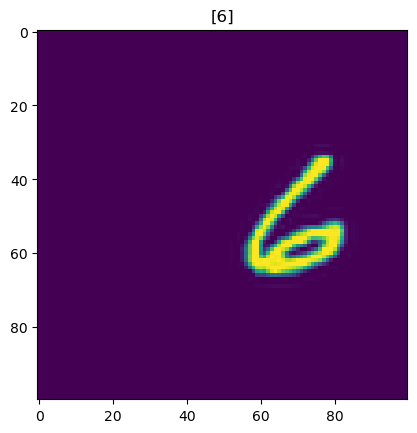

In [109]:
#plot examples to check if data was loaded correctly
for image, label in train.take(5):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy())
    plt.show()


#### Implement ViT Architecture
Based on the implementation found in the Karas documentation. [link](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

In [110]:
#define the hyperparameters
input_shape = (100, 100, 1)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 5
image_size = 100
patch_size = 16
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 8
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [111]:
#data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
images_dataset = train.map(lambda image, label: image)
data_augmentation.layers[0].adapt(images_dataset)

In [112]:
#implement MLP
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [113]:
#create a layer for creating the patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 100 X 100
Patch size: 16 X 16
Patches per image: 36
Elements per patch: 256


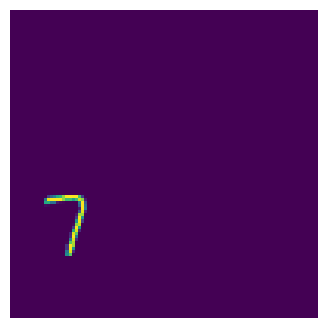

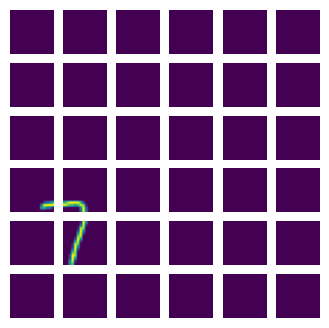

In [114]:
numpy_iterator = train.as_numpy_iterator()
plt.figure(figsize=(4, 4))
image, labels = next(numpy_iterator)

plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [115]:
#layer to encode patches in a vector of size projection_dim
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [116]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [117]:
num_classes = 10
train = train.batch(256)
validation = validation.batch(256)

In [118]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train,
        epochs=num_epochs,
        validation_data=validation,
        callbacks=[checkpoint_callback],
    )


    return history


vit_classifier = create_vit_classifier()
vit_classifier.summary()
vit_classifier.predict(image).shape
history = run_experiment(vit_classifier)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 100, 100, 1)  3          ['input_9[0][0]']                
                                                                                                  
 patches_16 (Patches)           (None, None, 256)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder_8 (PatchEncoder)  (None, 36, 64)      18752       ['patches_16[0][0]']       

                                                                                                  
 multi_head_attention_61 (Multi  (None, 36, 64)      132672      ['layer_normalization_130[0][0]',
 HeadAttention)                                                   'layer_normalization_130[0][0]']
                                                                                                  
 add_122 (Add)                  (None, 36, 64)       0           ['multi_head_attention_61[0][0]',
                                                                  'add_121[0][0]']                
                                                                                                  
 layer_normalization_131 (Layer  (None, 36, 64)      128         ['add_122[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 dense_155

 dense_162 (Dense)              (None, 36, 64)       8256        ['dropout_152[0][0]']            
                                                                                                  
 dropout_153 (Dropout)          (None, 36, 64)       0           ['dense_162[0][0]']              
                                                                                                  
 add_129 (Add)                  (None, 36, 64)       0           ['dropout_153[0][0]',            
                                                                  'add_128[0][0]']                
                                                                                                  
 layer_normalization_138 (Layer  (None, 36, 64)      128         ['add_129[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 multi_hea